In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import rankdata

from SSLTree import SSLTree


def encontrar_fila_con_palabra(ruta_archivo, palabra):
    with open(ruta_archivo, 'r') as archivo:
        for num_linea, linea in enumerate(archivo, 1):
            if palabra in linea:
                return num_linea
    return -1


def cross_val(name, p_unlabeled="20"):
    accuracy_ssl = []
    accuracy_dt = []
    accuracy_st = []

    print("PERCENTAGE:", p_unlabeled, "- DATASET:", name)
    for k in range(1, 11):
        train_data = pd.read_csv(
            f'datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
            header=None,
            skiprows=encontrar_fila_con_palabra(
                f'datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tra.dat',
                '@data'))

        test_data = pd.read_csv(
            f'datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
            header=None,
            skiprows=encontrar_fila_con_palabra(
                f'datasets/{p_unlabeled}/{name}-ssl{p_unlabeled}-10-fold/{name}-ssl{p_unlabeled}/{name}-ssl{p_unlabeled}-10-{k}tst.dat',
                '@data'))

        columnas_strings = train_data.iloc[:, :-1].select_dtypes(exclude=['number']).columns.tolist()

        for col in columnas_strings:
            encoder = LabelEncoder()
            train_data.iloc[:, col] = encoder.fit_transform(train_data.iloc[:, col])
            train_data[col] = train_data[col].apply(pd.to_numeric)
            test_data.iloc[:, col] = encoder.transform(test_data.iloc[:, col])
            test_data[col] = test_data[col].apply(pd.to_numeric)

        if pd.api.types.is_numeric_dtype(test_data.iloc[:, -1]):
            train_data.loc[train_data.iloc[:, -1] == ' unlabeled', len(train_data.columns) - 1] = -1
            train_data.iloc[:, -1] = pd.to_numeric(train_data.iloc[:, -1])
        else:
            label_encoder = LabelEncoder()
            # Codificar las etiquetas de clase
            train_data.iloc[:, -1] = label_encoder.fit_transform(train_data.iloc[:, -1])
            train_data.loc[train_data.iloc[:, -1] == label_encoder.transform([' unlabeled'])[0], len(
                train_data.columns) - 1] = -1

            test_data.iloc[:, -1] = label_encoder.transform(test_data.iloc[:, -1])

        train_data[train_data.columns[-1]] = train_data[train_data.columns[-1]].astype(int)
        test_data[test_data.columns[-1]] = test_data[test_data.columns[-1]].astype(int)

        train_data_label = train_data[train_data.iloc[:, -1] != -1]

        my_tree = SSLTree()
        my_tree.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)
        # print(my_tree.export_tree())
        # print(accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))

        dt = DecisionTreeClassifier()
        dt.fit(train_data_label.iloc[:, :-1].values, train_data_label.iloc[:, -1].values)
        # print(export_text(dt))
        # print(accuracy_score(test_data.iloc[:, -1].values, dt.predict(test_data.iloc[:, :-1].values)))

        self_training_model = SelfTrainingClassifier(DecisionTreeClassifier())
        self_training_model.fit(train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values)

        accuracy_ssl.append(
            accuracy_score(test_data.iloc[:, -1].values, my_tree.predict(test_data.iloc[:, :-1].values)))
        accuracy_dt.append(accuracy_score(test_data.iloc[:, -1].values, dt.predict(test_data.iloc[:, :-1].values)))
        accuracy_st.append(accuracy_score(test_data.iloc[:, -1].values,
                                          self_training_model.predict(test_data.iloc[:, :-1].values)))
        print("\tFOLD", k, "- Done")

    return np.median(accuracy_ssl), np.median(accuracy_dt), np.median(accuracy_st)

In [4]:
names = [
    # "abalone",
    "appendicitis",
    "australian",
    # "automobile",
    # "banana", best_left (puede ser porque tiene -1 en las etiquetas)
    # "breast",
    "bupa",
    # "chess",
    "cleveland",
    "coil2000",
    "contraceptive",
    # crx",
    "dermatology",
    "ecoli",
    "flare",
    "german",
    "glass",
    "haberman",
    "heart",
    "hepatitis",
    # "housevotes",
    "iris",
    "led7digit",
    # "lymphography",
    # "magic", tarda mucho
    "mammographic",
    "marketing",
    "monk-2",
    "movement_libras",
    # "mushroom",
    "nursery",
    "page-blocks",
    "penbased",
    "phoneme",
    # "pima",
    # "ring", no hay problema, pero tarda como dos milenios (aprox)
    "saheart",
    "satimage",
    "segment",
    "sonar",
    "spambase",
    "spectfheart",
    "splice",
    "tae",
    # "texture", no hay problema, pero tarda como tres milenios (aprox)
    "thyroid",
    "tic-tac-toe",
    # "titanic", tiene -1 en las etiquetas
    "twonorm",
    "vehicle",
    "vowel",
    "wine",
    "wisconsin",
    "yeast",
    "zoo"
]

In [5]:
all_medians = {}

all_mean_rankings = np.empty((3, 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    medians_ssl = []
    medians_dt = []
    medians_st = []
    for name in names:
        m_ssl, m_dt, m_st = cross_val(name, p)
        # break
        medians_ssl.append(m_ssl)
        medians_dt.append(m_dt)
        medians_st.append(m_st)
    # break
    print(medians_ssl)
    print(medians_dt)
    print(medians_st)

    all_medians[p] = np.stack((medians_ssl, medians_dt, medians_st))

    rankings = rankdata(-all_medians[p], method="average", axis=0)
    print(rankings)

    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

final_rankings = rankdata(all_mean_rankings, method="average", axis=0)
print(all_mean_rankings)

PERCENTAGE: 10 - DATASET: appendicitis
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: australian
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: bupa
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: cleveland
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: coil2000
	FOLD 1 - Done
	FOLD 2 - Done
	FOLD 3 - Done
	FOLD 4 - Done
	FOLD 5 - Done
	FOLD 6 - Done
	FOLD 7 - Done
	FOLD 8 - Done
	FOLD 9 - Done
	FOLD 10 - Done
PERCENTAGE: 10 - DATASET: contraceptive
	FOLD 1 - Done
	FOLD 2 - Do

KeyboardInterrupt: 

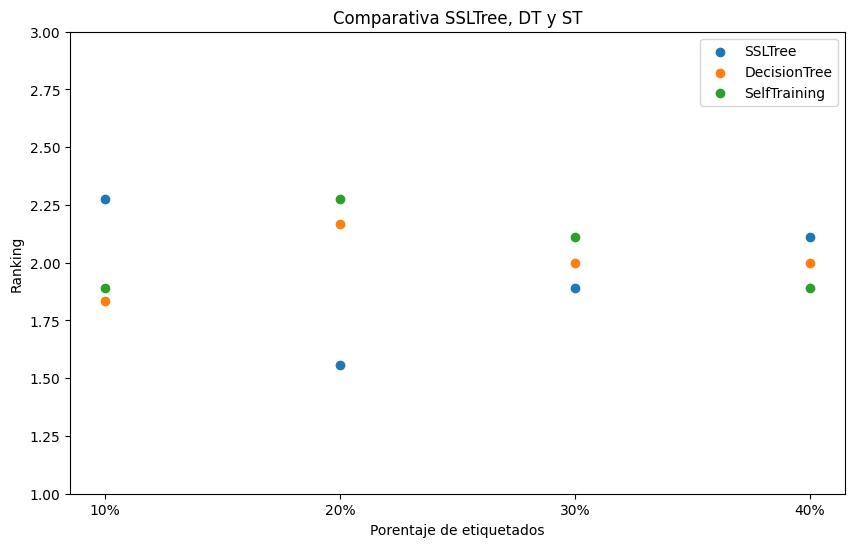

In [50]:
plt.figure(figsize=(10, 6))

for i, percentage in enumerate(["10%", "20%", "30%", "40%"]):
    top = all_mean_rankings[:, i].copy()
    uniques, _ = np.unique(top, return_counts=True)

    displacement = 0.05 * np.linspace(-1, 1, len(uniques), endpoint=False)
    dup = 0
    for j, value in enumerate(top):
        if np.count_nonzero(top == value) > 1:
            all_mean_rankings[j][i] += displacement[dup] if dup < len(displacement) else 0
            dup += 1

classifiers = ["SSLTree", "DecisionTree", "SelfTraining"]
for j, classifier in enumerate(classifiers):
    plt.scatter(["10%", "20%", "30%", "40%"], all_mean_rankings[j], label=classifier)

plt.ylim(1, 3)
plt.xlabel("Porentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa SSLTree, DT y ST")

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
# plt.scatter(medians_ssl, medians_dt, color='blue')
plt.plot([min(medians_ssl + medians_dt) * 0.7, 1],
         [min(medians_ssl + medians_dt) * 0.7, 1], color='red', linestyle='--')

colores = plt.cm.viridis(np.linspace(0, 1, len(medians_ssl)))

# Agregar los puntos al gráfico de dispersión uno por uno
for i in range(len(medians_ssl)):
    plt.scatter(medians_ssl[i], medians_dt[i], color=colores[i], label=names[i])

plt.legend()
plt.title("Median accuracy")
plt.show()